In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [10]:
# Load dataset

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
X, y = noisy_moons
X_data = StandardScaler().fit_transform(X)
x_lim, y_lim = [-2, 2], [-2, 2]

(-2.0, 2.0)

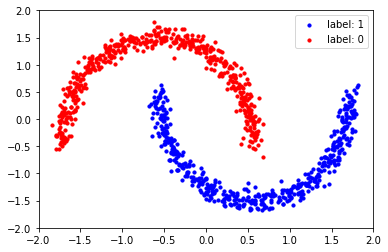

In [12]:
# Plot with labels

y_label = y.astype(np.bool)
X_train, Y_train = X_data[..., 0], X_data[..., 1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color='blue')
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color='red')
plt.legend(['label: 1', 'label: 0'])
plt.xlim(x_lim)
plt.ylim(y_lim)

In [34]:
# Define a base distribution

base_distribution = tfd.Normal(loc=[0,0], scale=1)
base_distribution = tfd.Independent(base_distribution, reinterpreted_batch_ndims=1)
base_distribution

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [35]:
# Define the trainable distribution

def make_masked_autoregressive_flow(hidden_units=[16, 16], activation='relu'):
    made = tfb.AutoregressiveNetwork(
        params=2, 
        event_shape=[2], 
        hidden_units=hidden_units,
        activation=activation)
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

trainable_distribution = tfd.TransformedDistribution(base_distribution,
                                                    make_masked_autoregressive_flow())

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [37]:
# Define a plot contour routine

def plot_contour_prob(dist, rows=1, title=[''], scale_fig=4):
    cols = int(len(dist) / rows)
    xx = np.linspace(-5.0, 5.0, 100)
    yy = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(xx, yy)

    fig, ax = plt.subplots(rows, cols, figsize=(scale_fig * cols, scale_fig * rows))
    fig.tight_layout(pad=4.5)

    i = 0
    for r in range(rows):
        for c in range(cols):
            Z = dist[i].prob(np.dstack((X, Y)))
            if len(dist) == 1:
                axi = ax
            elif rows == 1:
                axi = ax[c]
            else:
                axi = ax[r, c]

            # Plot contour
            p = axi.contourf(X, Y, Z)

            # Add a colorbar
            divider = make_axes_locatable(axi)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cbar = fig.colorbar(p, cax=cax)

            # Set title and labels
            axi.set_title('Filled Contours Plot: ' + str(title[i]))
            axi.set_xlabel('x')
            axi.set_ylabel('y')

            i += 1
    plt.show()

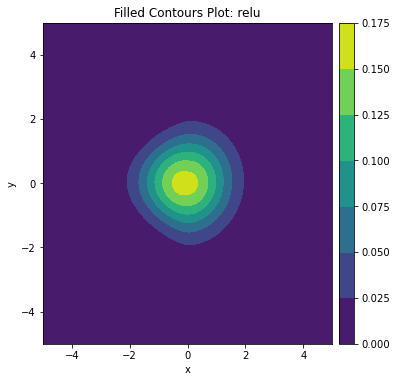

In [50]:
# Plot contour

activation='relu'
maf = tfd.TransformedDistribution(base_distribution,
                                 make_masked_autoregressive_flow(activation=activation),)
plot_contour_prob([maf], scale_fig=6, title=[activation])

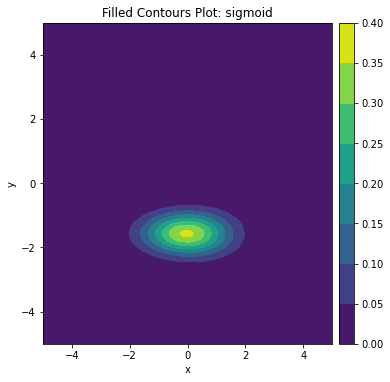

In [49]:
# Plot contour

activation='sigmoid'
maf = tfd.TransformedDistribution(base_distribution,
                                 make_masked_autoregressive_flow(activation=activation),)
plot_contour_prob([maf], scale_fig=6, title=[activation])

In [51]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

In [52]:
x = base_distribution.sample([1000, 2])
names = [base_distribution.name, trainable_distribution.bijector.name]
samples = [x, trainable_distribution.bijector.forward(x)]

In [53]:
# Define a scatter plot routine for the bijectors

def _plot(results, rows=1, legend=False):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(X, Y, s=10, color='red')
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(names[i])
            
            i += 1

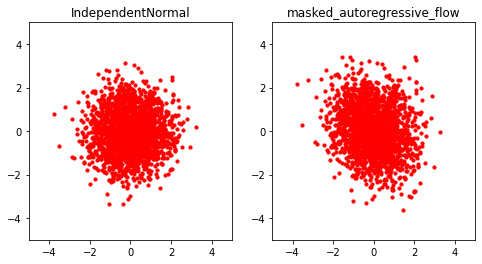

In [54]:
# plot

_plot(samples)

### Training a MaskedAutoregressiveFlow bijector

In [55]:
from tensorflow.keras.callbacks import LambdaCallback

In [56]:
# Define a training routine

def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=lambda _, log_prob: -log_prob)

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )


    history = model.fit(x=X_data,
                        y=np.zeros((ns, 0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback])
    return history

In [59]:
history = train_dist_routine(trainable_distribution, n_epochs=600, batch_size=None, n_disp=50)


 Epoch 1/600 
	 loss: 2.5862, val_loss: 2.6003

 Epoch 51/600 
	 loss: 2.5279, val_loss: 2.5358

 Epoch 101/600 
	 loss: 2.4241, val_loss: 2.4174

 Epoch 151/600 
	 loss: 2.2617, val_loss: 2.2398

 Epoch 201/600 
	 loss: 2.1306, val_loss: 2.1007

 Epoch 251/600 
	 loss: 2.0869, val_loss: 2.0570

 Epoch 301/600 
	 loss: 2.0603, val_loss: 2.0350

 Epoch 351/600 
	 loss: 2.0428, val_loss: 2.0230

 Epoch 401/600 
	 loss: 2.0324, val_loss: 2.0153

 Epoch 451/600 
	 loss: 2.0249, val_loss: 2.0086

 Epoch 501/600 
	 loss: 2.0194, val_loss: 2.0039

 Epoch 551/600 
	 loss: 2.0147, val_loss: 2.0004


In [60]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

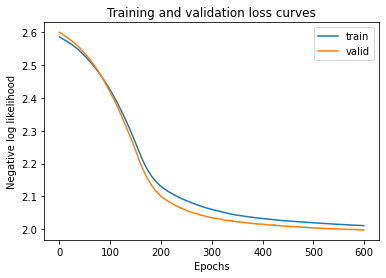

In [61]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel('Negative log likelihood')
plt.title('Training and validation loss curves')
plt.show()

In [62]:
# Make samples

x = base_distribution.sample([1000, 2])
names = [base_distribution.name, trainable_distribution.bijector.name]
samples = [x, trainable_distribution.bijector.forward(x)]

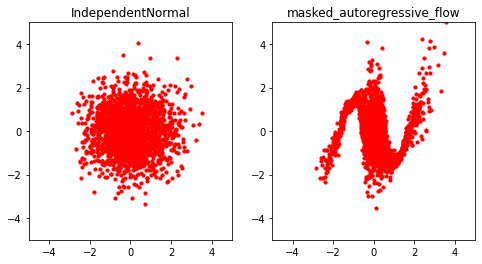

In [63]:
# plot

_plot(samples)

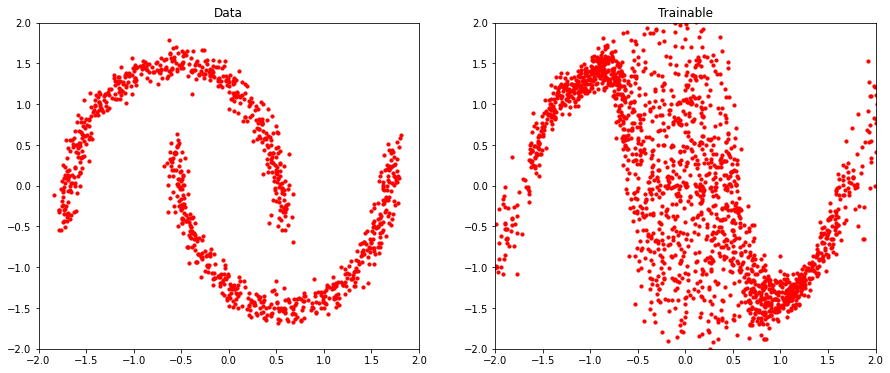

In [64]:
# Define a plot routine

def visualize_training_data(samples):
    f, arr = plt.subplots(1, 2, figsize=(15, 6))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color='red')
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

visualize_training_data(samples)

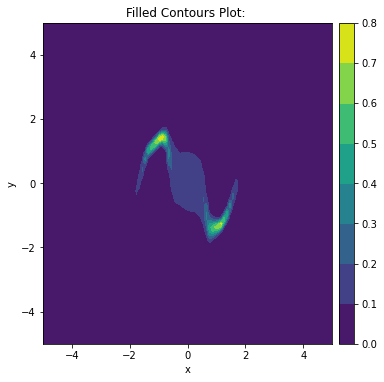

In [65]:
# Plot contour

plot_contour_prob([trainable_distribution], scale_fig=6)

### Train a chain of MaskedAutoregressiveFlow bijectors

In [80]:
# Define a more expressive model

num_bijectors = 6
bijectors = []

for i in range(num_bijectors):
    masked_auto_i = make_masked_autoregressive_flow(hidden_units=[256, 256], activation='relu')
    bijectors.append(masked_auto_i)
    bijectors.append(tfb.Permute(permutation=[1,0]))
    
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [81]:
# Define the trainable distribution

trainable_distribution = tfd.TransformedDistribution(distribution=base_distribution,
                                                    bijector=flow_bijector,)

In [82]:
# Make samples

def make_samples():
    x = base_distribution.sample((1000, 2))
    samples = [x]
    names = [base_distribution.name]
    for bijector in reversed(trainable_distribution.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

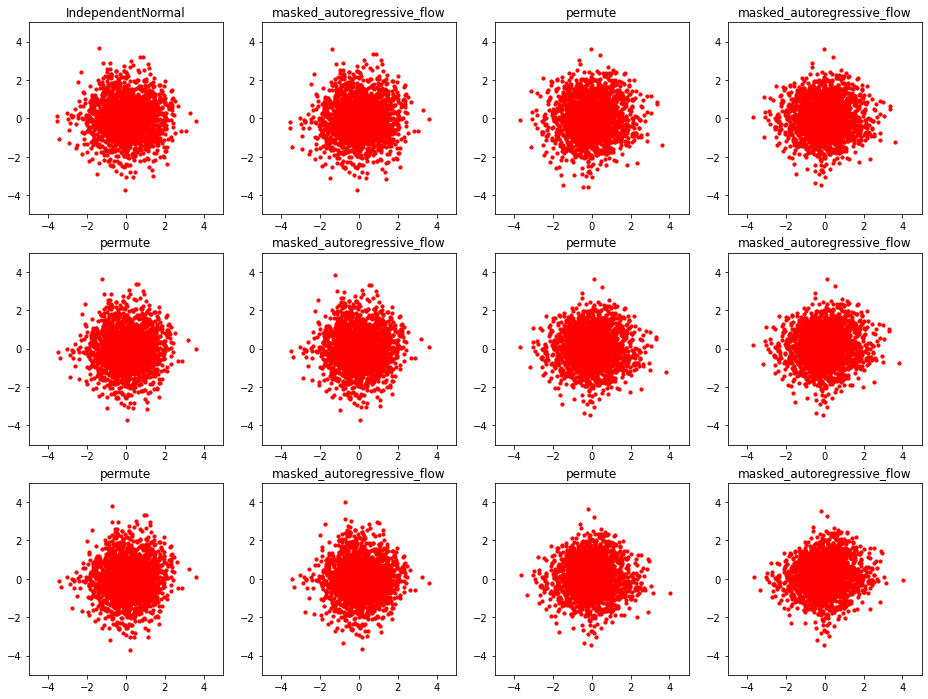

In [83]:
# Plot

_plot(samples, 3)

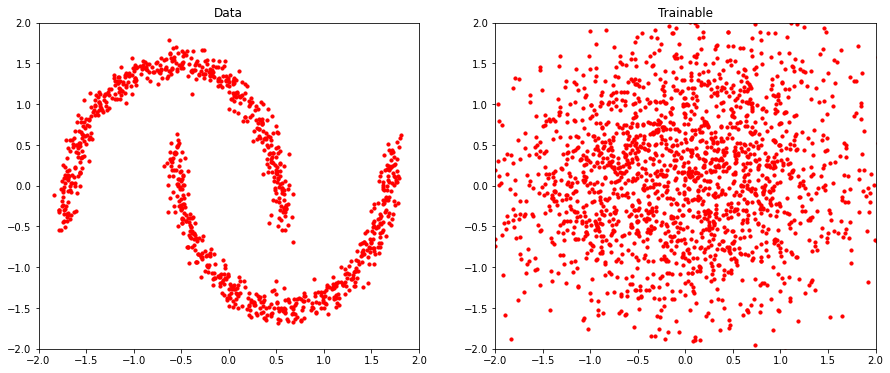

In [84]:
# Plot

visualize_training_data(samples)

In [85]:
# Train the distribution

history = train_dist_routine(trainable_distribution, n_epochs=600, n_disp=50)


 Epoch 1/600 
	 loss: 2.8980, val_loss: 2.6971

 Epoch 51/600 
	 loss: 2.1099, val_loss: 2.0750

 Epoch 101/600 
	 loss: 1.9020, val_loss: 1.9138

 Epoch 151/600 
	 loss: 2.0574, val_loss: 2.0673

 Epoch 201/600 
	 loss: 2.1210, val_loss: 2.1106

 Epoch 251/600 
	 loss: 1.7989, val_loss: 1.8130

 Epoch 301/600 
	 loss: 1.9699, val_loss: 1.9931

 Epoch 351/600 
	 loss: 1.5014, val_loss: 1.5378

 Epoch 401/600 
	 loss: 1.3942, val_loss: 1.4211

 Epoch 451/600 
	 loss: 1.3095, val_loss: 1.4227

 Epoch 501/600 
	 loss: 1.2931, val_loss: 1.3441

 Epoch 551/600 
	 loss: 1.1854, val_loss: 1.3324


In [86]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

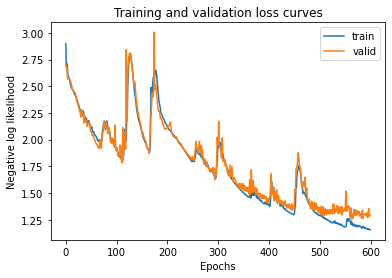

In [87]:
# Plot loss vs epochs

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

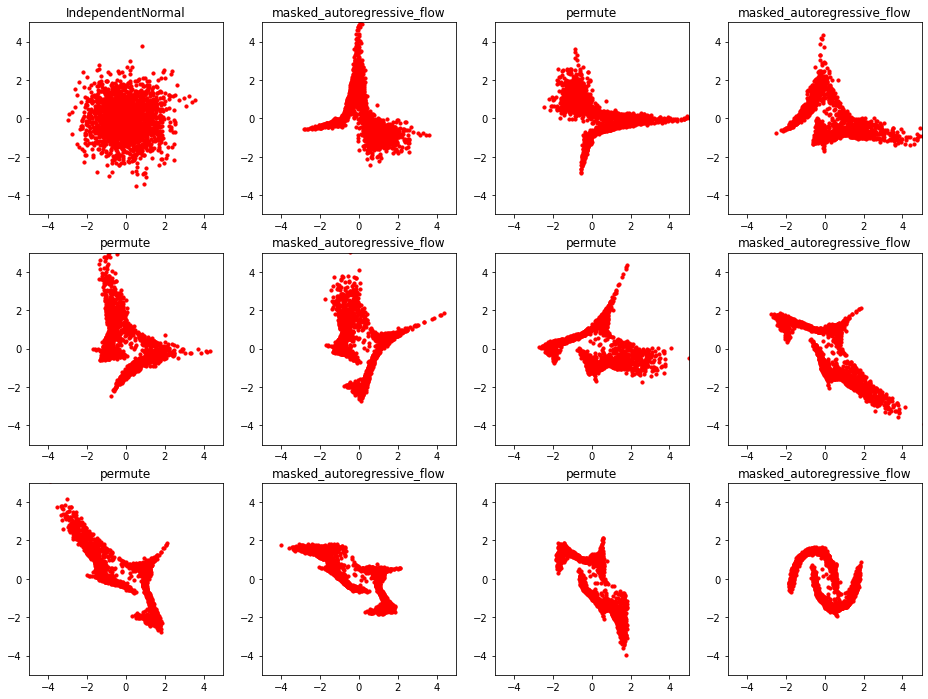

In [88]:
# Make samples and plot

names, samples = make_samples()
_plot(samples, 3)

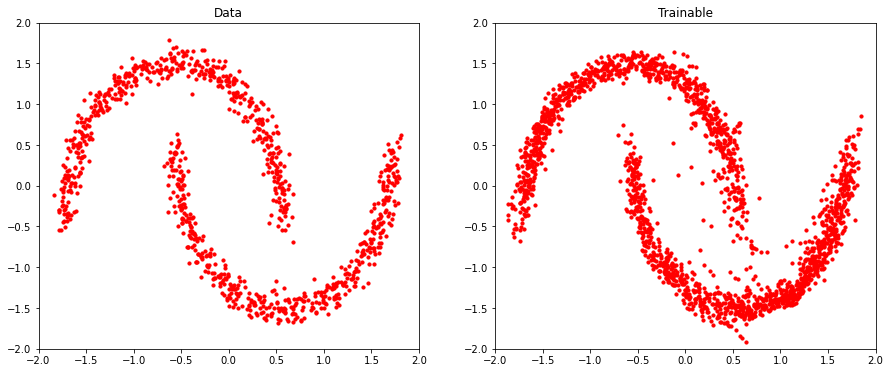

In [89]:
# Plot

visualize_training_data(samples)

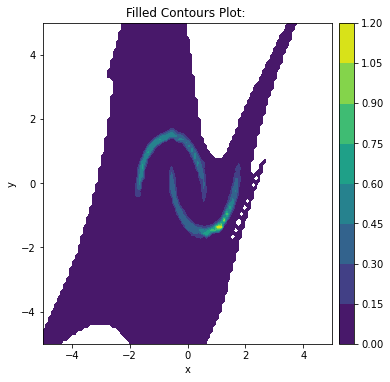

In [90]:
# Plot

plot_contour_prob([trainable_distribution], scale_fig=6)